In [31]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1]:
import pandas as pd
from yahoo_finance import Share
from datetime import datetime
import matplotlib
import math
import pyfolio as pf
from datetime import timedelta
import numpy as np

In [2]:
start, end = '2011-01-01','2015-10-26'

def price_data(symbol, start=start, end=end):
	x = pd.DataFrame(Share(symbol).get_historical(start, end))
	x.index = x.Date
	return x
#def price_data(symbol, start=start, end=end):
 #   x = pf.utils.get_symbol_from_yahoo(symbol, start, end)
  #  return x

def make_IVTS():
	vix = price_data('^VIX', start, end)
	vxv = price_data('^VXV', start, end)
	vix = vix.iloc[::-1]
	vxv = vxv.iloc[::-1]
	vix = vix.convert_objects(convert_numeric=True)
	vxv = vxv.convert_objects(convert_numeric=True)
	vix.index = [datetime.strptime(x, '%Y-%m-%d') for x in vix.Date]
	vxv.index = [datetime.strptime(x, '%Y-%m-%d') for x in vxv.Date]
	IVTS_1d = vix['Adj_Close']/vxv['Adj_Close']
	#IVTS_1d = vix['^VIX']/vxv['^VXV']
	IVTS_1d = pd.Series([np.median([IVTS_1d[i], IVTS_1d.shift(1)[i],IVTS_1d.shift(2)[i],
                                    IVTS_1d.shift(3)[i],IVTS_1d.shift(4)[i]]) 
           for i in range(len(IVTS_1d))], index = IVTS_1d.index)
           #for i in IVTS_1d.index], index = IVTS_1d.index)
	return IVTS_1d
        
### Set weights here ###    
def pos(val):
	if val > 1.005:
		return [-0.10, 0.90]
	elif val >= 0.97:
		return [-0.25, 0.75]
	elif val >= 0.94:
		return [-0.32,0.68]
	elif val >= 0.91:
		return [-0.32, 0.68]
	elif val < 0.91:
		return [-0.60, 0.40]
	else:
		return [0, 0]
    
def pos(val):
	if val > 1.02:
		return 1
	if val < 0.92:
		return -1
	else:
		return 0
    
def pos(val,a,b):
	if val > a:
		return 1
	if val < b:
		return -1
	else:
		return 0
        
def get_position(a,b):
	IVTS = make_IVTS()
	df = pd.DataFrame(IVTS)
        
	df['pos'] = IVTS.apply(pos, args = (a,b,))
	return df['pos'], IVTS


def get_rets(position, IVTS):
	pos1, pos2 = [pd.Series([position[i][0] for i in range(len(position))], index = position.index), 
                pd.Series([position[i][1] for i in range(len(position))], index = position.index)]
	vxx1 = pf.utils.get_symbol_rets('VXX', start, end)
	vxz1 = pf.utils.get_symbol_rets('VXZ', start, end)
	pos1 = pos1.tz_localize('UTC')
	pos2 = pos2.tz_localize('UTC')
	dif = vxx1 * pos1 + vxz1 * pos2  
	return dif

def get_rets2(position):
	vxx1 = pf.utils.get_symbol_rets('VXX', start, end)
	#vxz1 = pf.utils.get_symbol_rets('VXZ', start, end)
	position = position.tz_localize('UTC')
	dif = vxx1 * position
	return dif


def rets():
	dif, per, vxx, IVTS = get_rets()
	per2 = per+1
	return per2.product()

In [3]:
start_, end_ = '2011-01-01','2015-10-26'

In [8]:
#LOOPS THROUGH EACH MONTH WITH UPDATE

i = 0
end =start =  start_
a, b = 1.02,0.92

wfopt= []
while end < end_:
    start = datetime.strftime(datetime.strptime(start_, '%Y-%m-%d')+ i*timedelta(30), '%Y-%m-%d')
    end = datetime.strftime(datetime.strptime(start_, '%Y-%m-%d')+ (i+1)*timedelta(30), '%Y-%m-%d')
    print(start, end)
    
    position,  IVTS = get_position(a,b)
    dif= get_rets2(position)
    z = np.prod(dif+1)
    print(z)
    wfopt.append(z)
    
    r = [-0.02, -0.01, 0.01, 0.02]
    a_, b_ = a,b
    
    print('low threshold:')
    for k in r:
        position,  IVTS = get_position(a_ + k, b_)
        dif= get_rets2(position)
        z_ = np.prod(dif+1)
        print(z_)
        if z_>z:
            z=z_
            a = a_ + k
            print('changing a')
            print(a)
            
    a_, b_ = a,b
    print('high threshold:')
    for k in r:
        position,  IVTS = get_position(a_, b_ + k)
        dif= get_rets2(position)
        z_ = np.prod(dif+1)
        print(z_)
        if z_>z:
            z=z_
            b = b_ + k
            print('changing b')
            print(b)
            
    i = i+1

2011-01-01 2011-01-31
1.10187506633
low threshold:
1.10187506633
1.10187506633
1.10187506633
1.10187506633
high threshold:
1.10496285417
changing b
0.9
1.10187506633
1.10187506633
1.10187506633
2011-01-31 2011-03-02
0.88301576033
low threshold:
0.88301576033
0.88301576033
0.88301576033
0.88301576033
high threshold:
1.0
changing b
0.88
1.00997965783
changing b
0.89
0.904833227321
0.864247798932
2011-03-02 2011-04-01
1.0
low threshold:
0.863672577261
0.868190201038
1.0
1.0
high threshold:
1.0
1.0
1.03050293349
changing b
0.9
1.05662555244
changing b
0.91
2011-04-01 2011-05-01
1.20674465826
low threshold:
1.20674465826
1.20674465826
1.20674465826
1.20674465826
high threshold:
1.20674465826
1.20674465826
1.20674465826
1.20674465826
2011-05-01 2011-05-31
1.12016647914
low threshold:
1.12016647914
1.12016647914
1.12016647914
1.12016647914
high threshold:
1.02303081583
1.15167021286
changing b
0.9
1.17991968036
changing b
0.92
1.17991968036
2011-05-31 2011-06-30
1.0
low threshold:
1.0
1.0
1.0

/Users/liamconnell/anaconda/lib/python3.4/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [4]:
#LOOPS THROUGH EACH MONTH WITHOUT UPDATE

i = 0
end =start =  start_
a, b = 1.02,0.92
staticrets = []
while end < end_:
    start = datetime.strftime(datetime.strptime(start_, '%Y-%m-%d')+ i*timedelta(30), '%Y-%m-%d')
    end = datetime.strftime(datetime.strptime(start_, '%Y-%m-%d')+ (i+1)*timedelta(30), '%Y-%m-%d')
    print(start, end)
    
    
    position,  IVTS = get_position(a,b)
    dif= get_rets2(position)
    print(np.prod(dif+1))
    staticrets.append(np.prod(dif+1))
    i = i+1

2011-01-01 2011-01-31
1.10187506633
2011-01-31 2011-03-02
0.864247798932
2011-03-02 2011-04-01
1.04408036652
2011-04-01 2011-05-01
1.20674465826
2011-05-01 2011-05-31
1.17991968036
2011-05-31 2011-06-30
1.0
2011-06-30 2011-07-30
0.908701820934
2011-07-30 2011-08-29
1.3326410811
2011-08-29 2011-09-28
0.941234663093
2011-09-28 2011-10-28
0.92980292723
2011-10-28 2011-11-27
1.0
2011-11-27 2011-12-27
1.17411338894
2011-12-27 2012-01-26
1.31890589245
2012-01-26 2012-02-25
1.03755475235
2012-02-25 2012-03-26
1.48352263985
2012-03-26 2012-04-25
0.991656125046
2012-04-25 2012-05-25
0.950437865027
2012-05-25 2012-06-24
1.15327523707
2012-06-24 2012-07-24
1.08035665586
2012-07-24 2012-08-23
1.08201337246
2012-08-23 2012-09-22
1.30126517525
2012-09-22 2012-10-22
0.999675832331
2012-10-22 2012-11-21
1.09989383358
2012-11-21 2012-12-21
0.945350235533
2012-12-21 2013-01-20
1.16592702319
2013-01-20 2013-02-19
1.10686459663
2013-02-19 2013-03-21
1.05010066175
2013-03-21 2013-04-20
1.03928011381
2013-0

/Users/liamconnell/anaconda/lib/python3.4/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


#WFO specs:

In [1]:
print(np.prod(wfopt))              #5 years return
print((1-min(wfopt[-24:]))/100)    #worst month (as percent lost /100)
print(np.mean(wfopt[-24:]))        #average monthly return (subtract 1 and multiply by 100)
print(np.prod(wfopt[-11:]))        #2015 performance

NameError: name 'np' is not defined

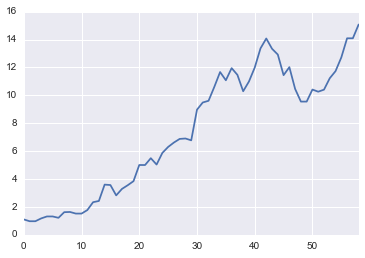

In [32]:
pd.Series(np.cumprod(wfopt)).plot()

#normal mojito:

In [44]:
print(np.prod(staticrets))                 #5 years return 
print(1-min(staticrets[-24:]))         #worst month 
print(np.mean(staticrets[-24:]))   #average monthly return (subtract 1 and multiply by 100)
np.prod(staticrets[-12:])       #last year of performance

12.7824577598
0.129962800249
1.00438123103


1.0848074072680705

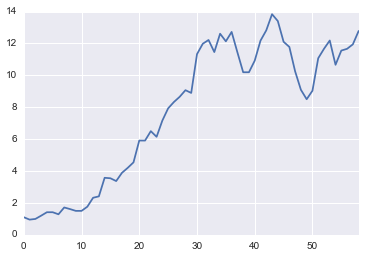

In [33]:
pd.Series(np.cumprod(staticrets)).plot()